## 0. Imports

In [39]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import time
from datetime import datetime
import math
from statistics import mode

# Data Splitting and Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Machine Learning Models
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import folium

# Tuning
from sklearn.model_selection import GridSearchCV

# Data Sampling and Optimization
from imblearn.over_sampling import SMOTE

## 1. Data Preprocessing

In [2]:
# Script to import data while reducing memory usage, work by Guillaume Martin
# https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
df_train = import_data('train.csv')
df_test = import_data('test.csv')

Memory usage of dataframe is 7.17 MB
Memory usage after optimization is: 2.09 MB
Decreased by 70.8%
Memory usage of dataframe is 1.57 MB
Memory usage after optimization is: 0.45 MB
Decreased by 71.2%


In [4]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (44760, 21)
Training Set Memory Usage = 2.09 MB
Test Set Shape = (10320, 20)
Test Set Memory Usage = 0.45 MB


In [5]:
df_train['location'] = df_train['lat'].astype(str) + '_' + df_train['lon'].astype(str)
df_test['location'] = df_test['lat'].astype(str) + '_' + df_test['lon'].astype(str)
unique_location_count = df_train['location'].nunique()
print("Number of unique locations:", unique_location_count)
unique_locations_train = df_train['location'].unique()

Number of unique locations: 120


In [6]:
m = folium.Map(location=[0, 0], zoom_start=2)

for location in unique_locations_train:
    lat, lon = location.split('_')
    location_name = f"Location: {location}"
    folium.Marker(
        location=[float(lat), float(lon)],
        icon=folium.Icon(icon='cloud'),
        popup=location_name
    ).add_to(m)
display(m)

In [8]:
data_train = df_train[['lat', 'lon']]
data_test = df_test[['lat', 'lon']]
combined_data = pd.concat([data_train, data_test], axis=0)

n_clusters = 7

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
combined_data['location_cluster'] = kmeans.fit_predict(combined_data)

df_train['location_cluster'] = combined_data['location_cluster'][:len(df_train)]
df_test['location_cluster'] = combined_data['location_cluster'][len(df_train):]

df_train.loc[df_train['location_cluster'] == 5, 'location_cluster'] = 0
df_test.loc[df_test['location_cluster'] == 5, 'location_cluster'] = 0
df_train.loc[df_train['location_cluster'] == 6, 'location_cluster'] = 3
df_test.loc[df_test['location_cluster'] == 6, 'location_cluster'] = 3
df_train.loc[df_train['location_cluster'] == 4, 'location_cluster'] = 2
df_test.loc[df_test['location_cluster'] == 4, 'location_cluster'] = 2

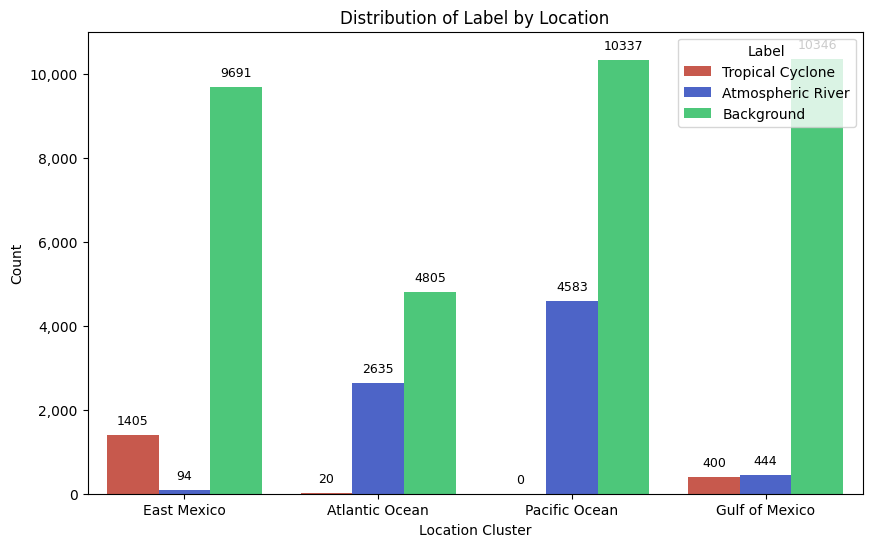

In [9]:
custom_palette = ['#DB4939', '#3957DB', '#39DB75']
label_mapping = {
    0: "Background",
    1: "Tropical Cyclone",
    2: "Atmospheric River"
}

location_labels = {
    0: "East Mexico",
    1: "Atlantic Ocean",
    2: "Pacific Ocean",
    3: "Gulf of Mexico"
}

df_train['CustomLabel'] = df_train['Label'].map(label_mapping)

plt.figure(figsize=(10, 6))
sns.set_palette(custom_palette)
ax = sns.countplot(data=df_train, x='location_cluster', hue='CustomLabel')
plt.title("Distribution of Label by Location")
plt.xlabel("Location Cluster")
plt.ylabel("Count")

ax.set_ylim(0,11000)
ax.set_xticklabels([location_labels.get(int(label), label) for label in ax.get_xticks()])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title="Label", loc="upper right")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()

df_train.drop('CustomLabel', axis=1, inplace=True)

In [10]:
# 0 missing values
na_counts = df_test.isna().sum().reset_index()
na_counts.columns = ['column', 'missing_values']
print(na_counts['missing_values'].sum())

0


In [11]:
# Some imbalance, not very extremly unbalanced
label_counts = df_train['Label'].value_counts()
total_samples = len(df_train)

print(f"{'Label':<20} {'Count':<10} {'Percentage':<10}")
print(f"{'Standard Background:':<20} {label_counts[0]:<10} {round(label_counts[0] / total_samples * 100, 2):<6}% of the dataset")
print(f"{'Tropical Cyclone:':<20} {label_counts[1]:<10} {round(label_counts[1] / total_samples * 100, 2):<6}% of the dataset")
print(f"{'Atmospheric River:':<20} {label_counts[2]:<10} {round(label_counts[2] / total_samples * 100, 2):<6}% of the dataset")

Label                Count      Percentage
Standard Background: 35179      78.59 % of the dataset
Tropical Cyclone:    1825       4.08  % of the dataset
Atmospheric River:   7756       17.33 % of the dataset


## 2. Feature Engineering

In [16]:
def feat_eng(df, is_vanilla=False):

    new_df = pd.DataFrame(df.copy())
    
    new_df['time'] = pd.to_datetime(df['time'], format='%Y%m%d', errors='coerce')
    new_df['year'] = new_df['time'].dt.year
    new_df['month'] = new_df['time'].dt.month
    
    if is_vanilla == False:
        new_df['month_sin'] = np.sin(2 * np.pi * new_df['time'].dt.month / 12)

        # Not a great future as the test set only comprises of fall and summer samples
        new_df['season'] = new_df['month'].apply(lambda x: 
        0 if 3 <= x <= 5 else
        1 if 6 <= x <= 8 else
        2 if 9 <= x <= 11 else
        3
        )

        #new_df = pd.get_dummies(new_df, columns=['season'], prefix='season')

        new_df['wind_velocity_850'] = np.sqrt(new_df['U850']**2 + df['V850']**2)

        new_df['avg_TMQ_location_last_biweek'] = new_df.groupby('location_cluster')['TMQ'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
        
        new_df['avg_TMQ_location'] = new_df.groupby('location_cluster')['TMQ'].transform('mean')
        new_df['diff_from_avg_TMQ'] = (new_df['TMQ'] - new_df['avg_TMQ_location'])
        new_df['PRECT'] = df['PRECT'] * 3600 * 60 * 24

        new_df = new_df.drop(columns=['location', 'lat', 'lon', 'SNo', 'time', 'avg_TMQ_location', 'UBOT', 'VBOT', 'T200', 'PS', 'PSL', 'Z200', 'ZBOT','Z1000', 'TS'])

    if is_vanilla == True:
        new_df = new_df.drop(columns=['location', 'SNo', 'time', 'location_cluster', 'month'])

    return new_df

In [17]:
df_train_mod = feat_eng(df_train, is_vanilla=False)
df_train_vanilla = feat_eng(df_train, is_vanilla=True)
df_train_mod

,TMQ,U850,V850,QREFHT,T500,PRECT,TREFHT,Label,location_cluster,year,month,month_sin,season,wind_velocity_850,avg_TMQ_location_last_biweek,diff_from_avg_TMQ
0,78.93750,-58.812500,36.187500,0.022324,273.00,71.994781,300.00,1,3,2003,10,-8.660254e-01,2,69.062500,78.937500,37.581810
1,78.93750,-58.812500,36.187500,0.022324,273.00,71.994781,300.00,1,3,2003,10,-8.660254e-01,2,69.062500,78.937500,37.581810
2,80.62500,-42.343750,58.062500,0.022202,273.50,74.775696,299.75,1,3,2003,10,-8.660254e-01,2,71.875000,79.500000,39.269310
3,80.62500,-42.343750,58.062500,0.022202,273.50,74.775696,299.75,1,3,2003,10,-8.660254e-01,2,71.875000,79.781250,39.269310
4,76.87500,-46.000000,42.687500,0.022324,272.25,51.292419,300.25,1,3,2003,10,-8.660254e-01,2,62.750000,79.200000,35.519310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44755,58.46875,26.390625,5.664062,0.021973,272.00,0.617981,300.50,1,0,2001,12,-2.449294e-16,3,26.984375,58.006696,15.908016
44756,58.46875,26.390625,5.664062,0.021973,272.00,0.617981,300.50,0,0,2001,12,-2.449294e-16,3,26.984375,58.058036,15.908016
44757,58.46875,26.390625,5.664062,0.021973,272.00,0.617981,300.50,1,0,2001,12,-2.449294e-16,3,26.984375,58.109375,15.908016
44758,58.46875,26.390625,5.664062,0.021973,272.00,0.617981,300.50,1,0,2001,12,-2.449294e-16,3,26.984375,58.160714,15.908016


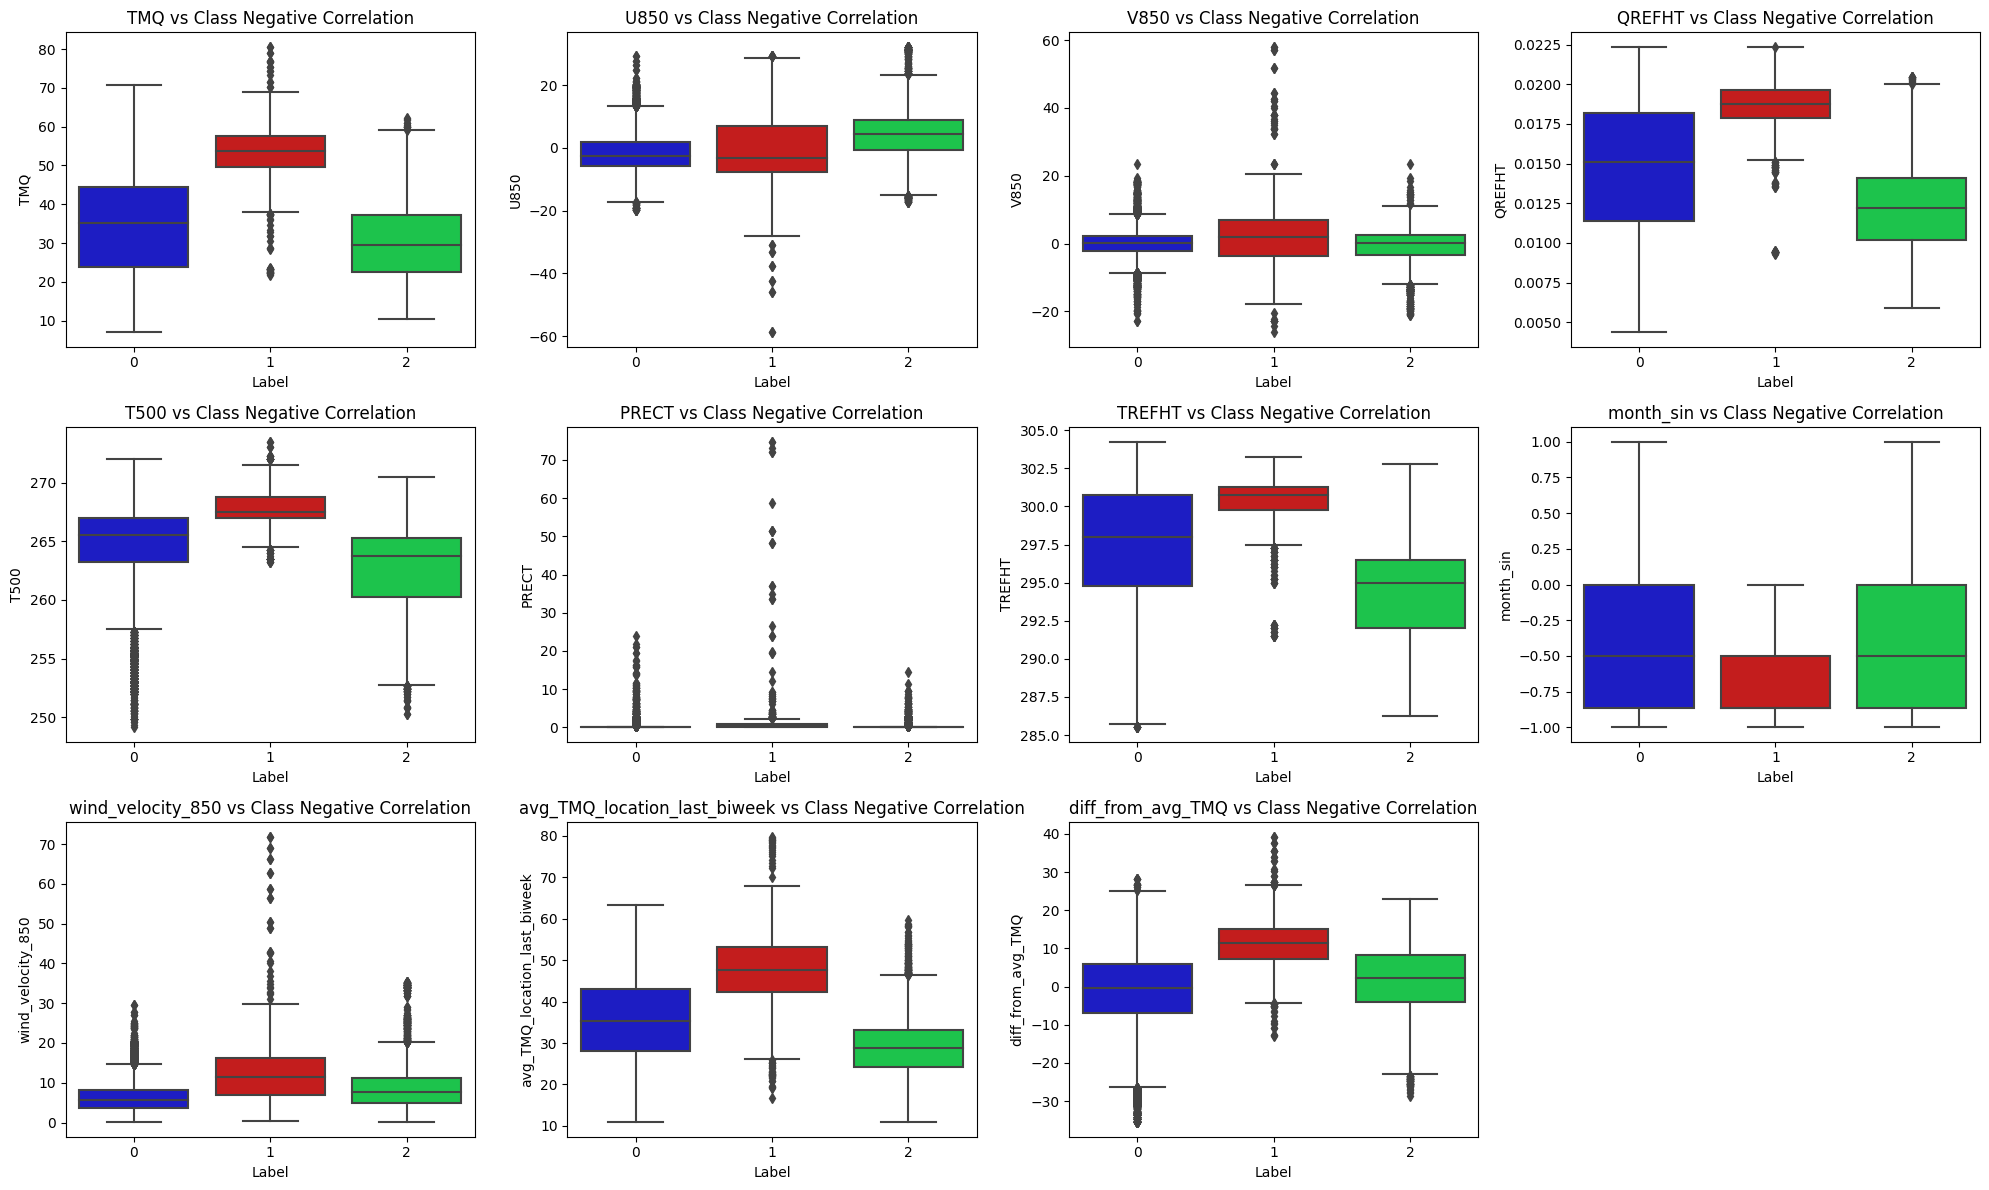

In [14]:
filtered_df = df_train_mod

features = filtered_df.columns.drop(['location_cluster', 'Label', 'year', 'month', 'season'])
colors = ["#0101DF", "#DF0101", "#01DF40"]

num_features = len(features)
num_cols = 4  # Number of columns per row
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x="Label", y=feature, data=filtered_df, palette=colors, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs Class Negative Correlation')

for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.tight_layout()
plt.show()

## 3. Machine Learning Models

In [20]:
# Function to print pretty confusion matrix
def confusion_matrix2(y_true, y_pred, num_classes, verbose=False):
    confusion_matrix = np.zeros((num_classes, num_classes))

    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]
        confusion_matrix[true_label][pred_label] += 1

    sensitivities = []
    specificities = []
    for class_index in range(num_classes):
        true_positives = confusion_matrix[class_index][class_index]
        false_positives = np.sum(confusion_matrix[class_index, :]) - true_positives
        false_negatives = np.sum(confusion_matrix[:, class_index]) - true_positives
        true_negatives = np.sum(confusion_matrix) - true_positives - false_positives - false_negatives

        sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
        specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) != 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        if verbose:
            print(f"Class {class_index} Sensitivity: {sensitivity:.6f}")
            print(f"Class {class_index} Specificity: {specificity:.6f}")

    if verbose:
        print("Confusion matrix")
        max_val = int(np.max(confusion_matrix))
        max_val_length = len(str(max_val)) + 1

        for i in range(num_classes):
            row = ""
            for j in range(num_classes):
                val = int(confusion_matrix[i, j])
                row += f"| {val:>{max_val_length}} "
            print(row)

    return confusion_matrix, sensitivities, specificities

In [21]:
YEAR_START = 1996
YEAR_TRAIN = 2006
YEAR_TEST = 2009
oversample= True

# Filter data for the training set (1996-2006)
X_train = df_train_mod[(df_train_mod['year'] >= YEAR_START) & (df_train_mod['year'] < YEAR_TRAIN)]

# Class weights chosen through tuning
if oversample:
    unique_clusters = X_train['location_cluster'].unique()
    oversampled_dfs = []
    for cluster in unique_clusters:
        if cluster == 3: 
            weights = {0: 10346, 1: 2000, 2: 2000}
            oversampler = SMOTE(random_state=42, sampling_strategy=weights)
        if cluster == 2: 
            weights = {0: 10338, 2: 4584}
            oversampler = SMOTE(random_state=42, sampling_strategy=weights)
        if cluster == 1: 
            weights = {0: 4805, 1: 500, 2: 2635}
            oversampler = SMOTE(random_state=42, sampling_strategy=weights)
        if cluster == 0: 
            weights = {0: 9691, 1: 1500, 2: 2500}
            oversampler = SMOTE(random_state=42, sampling_strategy=weights)
        cluster_df = X_train[X_train['location_cluster'] == cluster]
        X = cluster_df.drop(columns=['Label'])  
        y = cluster_df['Label']
        X_resampled, y_resampled = oversampler.fit_resample(X, y)
        resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
        oversampled_dfs.append(resampled_df)
    X_train = pd.concat(oversampled_dfs)

y_train = X_train['Label'].values
X_train = X_train.drop(columns=['Label', 'month', 'year'])
X_train = pd.get_dummies(X_train, columns=['location_cluster'], prefix='location')


# Filter data for the test set (2006-2009)
X_val = df_train_mod[(df_train_mod['year'] >= YEAR_TRAIN) & (df_train_mod['year'] <= YEAR_TEST)]
y_val = X_val['Label'].values
X_val = X_val.drop(columns=['Label', 'month', 'year'])
X_val = pd.get_dummies(X_val, columns=['location_cluster'], prefix='location')

### 3.1 Logistic Regression (From Scratch) with vanilla dataset - BASELINE MODEL

In [40]:
class MultiClassLogisticRegression:
    def __init__(self, learning_rate, n_iterations):
        self.learning_rate = learning_rate # Learning rate for gradient descent
        self.n_iterations = n_iterations   # Number of training iterations

    def softmax_score(self, x, weights):
        # Calculate the linear scores for each class for input data 'x' using weights
        score = x@weights
        return score
    
    def softmax_function(self, score):
        # Compute the softmax probabilities for each class based on the scores
        exps = np.exp(score)
        exps_sums = np.sum(exps, axis=1, keepdims=True)
        return exps / exps_sums

    def one_hot_y(self, y):
        # Convert the target labels 'y' into one-hot encoded format
        num_classes = len(np.unique(y))
        y_one_hot = np.eye(num_classes)[y]
        return y_one_hot

    def bias_and_normalize(self, X):
        # Add a bias term (1) to the input data and normalize the features (for computation purposes)
        X_with_bias = np.c_[np.ones([len(X), 1]), X]
        max_values = np.max(X_with_bias, axis=0)
        X_normalized = X_with_bias / max_values
        return X_normalized

    def predict(self, X):
        # Make predictions for input data 'X' using the trained model
        X = self.bias_and_normalize(X)
        score = self.softmax_score(X, self.weights)
        p_hat = self.softmax_function(score)
        y_hat = np.argmax(p_hat, axis=1)
        return y_hat

    def test(self, X, y):
        # Test the model's accuracy on input data 'X' and real labels 'y'
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def loss(self, y, p_hat):
        # Compute the cross-entropy loss between predicted probabilities 'p_hat' and true labels 'y'
        espilon = 1e-6 # Add espilon in case p_hat is 0 to avoid inf loss
        loss = -np.mean(np.sum(np.log(p_hat + espilon) * y, axis=1))
        return loss

    def gradient(self, p_hat, weights, y, x, learning_rate, m):
        # Compute the gradient for updating the model weights
        cost = p_hat - y
        gradients = 1/m * x.T.dot(cost)
        weights = weights - learning_rate*gradients
        return weights

    def fit(self, X, y):
        # Train the model on input data 'X' and labels 'y'
        n_outputs = len(np.unique(y))
        X = self.bias_and_normalize(X)
        y = self.one_hot_y(y)
        n_inputs = X.shape[1]
        m = X.shape[0]
        self.weights = np.random.randn(n_inputs, n_outputs)

        for epoch in range(self.n_iterations):
            score = self.softmax_score(X[:m], self.weights)
            p_hat = self.softmax_function(score)
            self.weights = self.gradient(p_hat, self.weights, y[:m], X[:m], self.learning_rate, m)

In [41]:
# Using Vanilla Features (as requested)
X_train_vanilla = df_train_vanilla[(df_train_vanilla['year'] >= YEAR_START) & (df_train_vanilla['year'] < YEAR_TRAIN)].drop(columns=['Label', 'year'])
y_train_vanilla = df_train_vanilla[(df_train_vanilla['year'] >= YEAR_START) & (df_train_vanilla['year'] < YEAR_TRAIN)]['Label'].values
X_val_vanilla = df_train_vanilla[(df_train_vanilla['year'] >= YEAR_TRAIN) & (df_train_vanilla['year'] <= YEAR_TEST)].drop(columns=['Label', 'year'])
y_val_vanilla = df_train_vanilla[(df_train_vanilla['year'] >= YEAR_TRAIN) & (df_train_vanilla['year'] <= YEAR_TEST)]['Label'].values

lr = MultiClassLogisticRegression(learning_rate=0.4, n_iterations=10000)
lr.fit(X_train_vanilla, y_train_vanilla)
y_pred_lr = lr.predict(X_val_vanilla)
accuracy = lr.test(X_val_vanilla, y_val)
print("Accuracy on the validation set: {:.10f}%".format(accuracy * 100))
cm = confusion_matrix2(y_val, y_pred_lr, verbose=True, num_classes=3)

Accuracy on the validation set: 79.2759562842%
Class 0 Sensitivity: 0.841029
Class 0 Specificity: 0.572452
Class 1 Sensitivity: 0.402516
Class 1 Specificity: 0.944421
Class 2 Sensitivity: 0.582498
Class 2 Specificity: 0.906476
Confusion matrix
|  5100 |    90 |   447 
|   387 |    64 |    11 
|   577 |     5 |   639 


### 3.2 Light Gradient Boosting

In [23]:
%%time

# Baseline

lgbm = lgb.LGBMClassifier(objective='multiclass', num_class= 3, random_state=5)
lgbm.fit(X_train_vanilla, y_train_vanilla)
acc = accuracy_score((y_val_vanilla), (lgbm.predict(X_val_vanilla)))
print("The classification accuracy on test set of the LGBM: {:.7%}".format(acc))
cm = confusion_matrix2(y_val_vanilla, (lgbm.predict(X_val_vanilla)), num_classes=3, verbose=True)

The classification accuracy on test set of the LGBM: 78.9071038%
Class 0 Sensitivity: 0.839974
Class 0 Specificity: 0.562549
Class 1 Sensitivity: 0.620339
Class 1 Specificity: 0.960285
Class 2 Sensitivity: 0.524590
Class 2 Specificity: 0.888241
Confusion matrix
|  5081 |    92 |   464 
|   279 |   183 |     0 
|   689 |    20 |   512 
CPU times: total: 4.72 s
Wall time: 917 ms


In [24]:
%%time

# Baseline

lgbm = lgb.LGBMClassifier(objective='multiclass', num_class= 3, random_state=5)
lgbm.fit(X_train, y_train)
acc = accuracy_score((y_val), (lgbm.predict(X_val)))
print("The classification accuracy on test set of the LGBM: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, (lgbm.predict(X_val)), num_classes=3, verbose=True)

The classification accuracy on test set of the LGBM: 80.5874317%
Class 0 Sensitivity: 0.844976
Class 0 Specificity: 0.620017
Class 1 Sensitivity: 0.507937
Class 1 Specificity: 0.956888
Class 2 Sensitivity: 0.636574
Class 2 Specificity: 0.896066
Confusion matrix
|  5189 |   134 |   314 
|   302 |   160 |     0 
|   650 |    21 |   550 
CPU times: total: 5.03 s
Wall time: 952 ms


In [25]:
%%time

# Tuned (after grid search)

lgbm_tuned = lgb.LGBMClassifier(objective='multiclass', num_class= 3, random_state=5, n_estimators=100, learning_rate=0.1, max_depth=3)
lgbm_tuned.fit(X_train, y_train)
acc = accuracy_score((y_val), (lgbm_tuned.predict(X_val)))
print("The classification accuracy on test set of the LGBM: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, (lgbm_tuned.predict(X_val)), num_classes=3, verbose=True)

The classification accuracy on test set of the LGBM: 82.3907104%
Class 0 Sensitivity: 0.855824
Class 0 Specificity: 0.691369
Class 1 Sensitivity: 0.584570
Class 1 Specificity: 0.962051
Class 2 Sensitivity: 0.680247
Class 2 Specificity: 0.897081
Confusion matrix
|  5283 |    95 |   259 
|   265 |   197 |     0 
|   625 |    45 |   551 
CPU times: total: 3.39 s
Wall time: 650 ms


### 3.3 XGBoost

In [26]:
%%time

# Baseline

xgbm = xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=2)
                        
xgbm.fit(X_train, y_train)
acc = accuracy_score((y_val), (xgbm.predict(X_val)))
print("The classification accuracy on test set of the XGB: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, (xgbm.predict(X_val)), num_classes=3, verbose=True)

The classification accuracy on test set of the XGB: 79.3306011%
Class 0 Sensitivity: 0.846952
Class 0 Specificity: 0.570475
Class 1 Sensitivity: 0.455090
Class 1 Specificity: 0.955626
Class 2 Sensitivity: 0.588757
Class 2 Specificity: 0.901047
Confusion matrix
|  5058 |   162 |   417 
|   310 |   152 |     0 
|   604 |    20 |   597 
CPU times: total: 1min
Wall time: 10.8 s


In [27]:
# Example of how XGBM was tuned iteratively (more parameters would be in the grid normally)

param_grid = {
    'max_depth': [1, 2]
}

grid_search = GridSearchCV(xgbm, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=3,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1, param_grid={'max_depth': [1, 2]}, verbose=3)

In [28]:
%%time

# Tuned (after grid search)

xgbm_tuned = xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=5, eta=0.05, max_depth = 3, n_estimators = 100, eval_metric = 'map')
                        
xgbm_tuned.fit(X_train, y_train)
acc = accuracy_score((y_val), (xgbm_tuned.predict(X_val)))
print("The classification accuracy on test set of the XGB: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, (xgbm_tuned.predict(X_val)), num_classes=3, verbose=True)

The classification accuracy on test set of the XGB: 82.2404372%
Class 0 Sensitivity: 0.850375
Class 0 Specificity: 0.708849
Class 1 Sensitivity: 0.626263
Class 1 Specificity: 0.960701
Class 2 Sensitivity: 0.667109
Class 2 Specificity: 0.890649
Confusion matrix
|  5331 |    70 |   236 
|   261 |   186 |    15 
|   677 |    41 |   503 
CPU times: total: 33.3 s
Wall time: 5.34 s


### 3.4 Random Forest

In [29]:
%%time

#Baseline

rf = RandomForestClassifier(random_state=5)
                        
rf.fit(X_train, y_train)
acc = accuracy_score((y_val), (rf.predict(X_val)))
print("The classification accuracy on test set of the RF: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, (rf.predict(X_val)), num_classes=3, verbose=True)

The classification accuracy on test set of the RF: 77.9644809%
Class 0 Sensitivity: 0.828311
Class 0 Specificity: 0.532599
Class 1 Sensitivity: 0.471264
Class 1 Specificity: 0.946823
Class 2 Sensitivity: 0.536246
Class 2 Specificity: 0.892127
Confusion matrix
|  5085 |    85 |   467 
|   380 |    82 |     0 
|   674 |     7 |   540 
CPU times: total: 8.59 s
Wall time: 8.77 s


In [30]:
# Example of how RF was tuned iteratively (more parameters would be in the grid normally)

param_grid = {
    'n_estimators': [10, 50] 
}

rf = RandomForestClassifier(random_state=2)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'n_estimators': [10, 50]}, verbose=3)

In [31]:
%%time

# Tuned (after grid search)

rf_tuned = RandomForestClassifier(random_state=5, n_estimators=300, bootstrap=False, max_depth=7)
rf_tuned.fit(X_train, y_train)
acc = accuracy_score((y_val), (rf_tuned.predict(X_val)))
print("The classification accuracy on test set of the RF: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, (rf_tuned.predict(X_val)), num_classes=3, verbose=True)

The classification accuracy on test set of the RF: 80.9972678%
Class 0 Sensitivity: 0.824479
Class 0 Specificity: 0.705726
Class 1 Sensitivity: 0.686567
Class 1 Specificity: 0.948511
Class 2 Sensitivity: 0.682334
Class 2 Specificity: 0.880650
Confusion matrix
|  5416 |    31 |   190 
|   364 |    92 |     6 
|   789 |    11 |   421 
CPU times: total: 21 s
Wall time: 22.2 s


### 3.5 K-NN

In [32]:
%%time

knn = KNeighborsClassifier(n_neighbors=8) # Tuned by hand
knn.fit(X_train, y_train)
acc = accuracy_score(y_val, knn.predict(X_val))
print("The classification accuracy on the validation set of the KNN model: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, knn.predict(X_val), num_classes=3, verbose=True)

The classification accuracy on the validation set of the KNN model: 71.3251366%
Class 0 Sensitivity: 0.822774
Class 0 Specificity: 0.412698
Class 1 Sensitivity: 0.295732
Class 1 Specificity: 0.947797
Class 2 Sensitivity: 0.342748
Class 2 Specificity: 0.871547
Confusion matrix
|  4675 |   225 |   737 
|   241 |    97 |   124 
|   766 |     6 |   449 
CPU times: total: 11.7 s
Wall time: 2.15 s


## 4. Ensemble Modelling

In [33]:
# Define models
models = [
    lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=5, n_estimators=100, learning_rate=0.1, max_depth=3),
    xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=5, eta=0.05, max_depth=3, n_estimators=100, eval_metric='map'),
    xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=5, eta=0.05, max_depth=4, n_estimators=100, eval_metric='map'),
    xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=5, eta=0.05, max_depth=3, n_estimators=400, eval_metric='map'),
    RandomForestClassifier(random_state=5, n_estimators=375, bootstrap=True, max_depth=7)
]

# Train and make predictions for each model
final_predictions = []

for model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    final_predictions.append(preds)
    acc = accuracy_score((y_val), (preds))
    print("The classification accuracy on test set of the single model: {:.7%}".format(acc))
    cm = confusion_matrix2(y_val, (preds), num_classes=3, verbose=True)

final_predictions.append(y_pred_lr) # Add predictions from LR

# Combine the predictions and get the mode
final_predictions = list(map(list, zip(*final_predictions)))  # Transpose the list of predictions
final_predictions = [mode(prediction) for prediction in final_predictions]

The classification accuracy on test set of the single model: 82.5273224%
Class 0 Sensitivity: 0.859853
Class 0 Specificity: 0.685477
Class 1 Sensitivity: 0.577143
Class 1 Specificity: 0.962697
Class 2 Sensitivity: 0.679532
Class 2 Specificity: 0.901005
Confusion matrix
|  5258 |   105 |   274 
|   260 |   202 |     0 
|   597 |    43 |   581 
The classification accuracy on test set of the single model: 82.1174863%
Class 0 Sensitivity: 0.849865
Class 0 Specificity: 0.712223
Class 1 Sensitivity: 0.628378
Class 1 Specificity: 0.960706
Class 2 Sensitivity: 0.655451
Class 2 Specificity: 0.888399
Confusion matrix
|  5338 |    69 |   230 
|   250 |   186 |    26 
|   693 |    41 |   487 
The classification accuracy on test set of the single model: 82.1174863%
Class 0 Sensitivity: 0.849108
Class 0 Specificity: 0.704981
Class 1 Sensitivity: 0.614583
Class 1 Specificity: 0.959471
Class 2 Sensitivity: 0.667989
Class 2 Specificity: 0.890920
Confusion matrix
|  5329 |    70 |   238 
|   272 |   177

In [34]:
acc = accuracy_score((y_val), (final_predictions))
print("The classification accuracy on test set of the ensemble: {:.7%}".format(acc))
cm = confusion_matrix2(y_val, (final_predictions), num_classes=3, verbose=True)

The classification accuracy on test set of the ensemble: 82.6502732%
Class 0 Sensitivity: 0.853068
Class 0 Specificity: 0.709917
Class 1 Sensitivity: 0.641026
Class 1 Specificity: 0.959273
Class 2 Sensitivity: 0.683623
Class 2 Specificity: 0.897145
Confusion matrix
|  5324 |    58 |   255 
|   287 |   175 |     0 
|   630 |    40 |   551 


## 5. Submission

In [35]:
df_test = feat_eng(df_test)
df_test = df_test.drop(columns=['year', 'month'])
df_test = pd.get_dummies(df_test, columns=['location_cluster'], prefix='location')

In [36]:
final_predictions = []

# Post Kaggle competition ending, I realize that I don't train on the given dataset, (i.e., train on full X, y instead of X_train, y_train),
# This could potentially have given a better score.

for model in models:
    preds = model.predict(df_test)
    final_predictions.append(preds)

# final_predictions.append(lr.predict(df_test)) Predictions of LR

# Combine the predictions and get the mode
final_predictions = list(map(list, zip(*final_predictions)))  
final_predictions = [mode(prediction) for prediction in final_predictions]

In [38]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d_%H-%M")
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["Label"] = final_predictions
note = "final_model"

sample_submission.to_csv(f"submissions/submission_{formatted_time}_{note}.csv", index=False)